In [ ]:
# This prototype was built with the lightest dataset from the recommenders library just as a test-drive of the ALS function
# To be done: Adapt it to MIND (it's actually included on recommenders).

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import sys
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import pyspark
from pyspark.sql import SparkSession
from pyspark.ml.recommendation import ALS
import pyspark.sql.functions as F
from pyspark.sql.functions import col
from pyspark.ml.tuning import CrossValidator
from pyspark.sql.types import StructType, StructField
from pyspark.sql.types import FloatType, IntegerType, LongType

from recommenders.datasets import movielens
from recommenders.utils.spark_utils import start_or_get_spark
from recommenders.evaluation.spark_evaluation import SparkRankingEvaluation, SparkRatingEvaluation
from recommenders.tuning.parameter_sweep import generate_param_grid
from recommenders.datasets.spark_splitters import spark_random_split

print(f"System version: {sys.version}")
print(f"Pandas version: {pd.__version__}")
print(f"PySpark version: {pyspark.__version__}")

System version: 3.10.12 (main, Nov  6 2024, 20:22:13) [GCC 11.4.0]
Pandas version: 2.2.3
PySpark version: 3.5.3


In [2]:
MOVIELENS_DATA_SIZE = "100k"

COL_USER = "UserId"
COL_ITEM = "MovieId"
COL_RATING = "Rating"
COL_PREDICTION = "prediction"
COL_TIMESTAMP = "Timestamp"

In [3]:
schema = StructType(
    (
        StructField(COL_USER, IntegerType()),
        StructField(COL_ITEM, IntegerType()),
        StructField(COL_RATING, FloatType()),
        StructField(COL_TIMESTAMP, LongType()),
    )
)

In [4]:
#Model hyperparameters, these are selected based on benchmarking results
# MediaLite experiments: http://mymedialite.net/examples/datasets.html 

RANK = 10
MAX_ITER = 15
REG_PARAM = 0.05

In [5]:
#N° of recommended items
K = 10 # Try with 5 next time

In [6]:
# #Initialize Spark Session

spark = start_or_get_spark("ALS Deep Dive", memory="16g")
spark.conf.set("spark.sql.analyzer.failAmbiguousSelfJoin", "false")

your 131072x1 screen size is bogus. expect trouble
24/12/02 14:36:14 WARN Utils: Your hostname, DESKTOP-LQJ6T08 resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
24/12/02 14:36:14 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/02 14:36:15 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/12/02 14:36:16 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


### Load and prepare data
Into a Spark DF

In [7]:
dfs = movielens.load_spark_df(spark=spark, size=MOVIELENS_DATA_SIZE, schema=schema)

100%|██████████| 4.81k/4.81k [00:01<00:00, 2.78kKB/s]


In [8]:
dfs.show(5)

+------+-------+------+---------+
|UserId|MovieId|Rating|Timestamp|
+------+-------+------+---------+
|   196|    242|   3.0|881250949|
|   186|    302|   3.0|891717742|
|    22|    377|   1.0|878887116|
|   244|     51|   2.0|880606923|
|   166|    346|   1.0|886397596|
+------+-------+------+---------+
only showing top 5 rows



In [9]:
#Split 80-20 (no validation for now)

dfs_train, dfs_test = spark_random_split(dfs, ratio=0.8, seed=42)

In [10]:
## Train a model on movielens

als = ALS(
    maxIter=MAX_ITER, 
    rank=RANK,
    regParam=REG_PARAM, 
    userCol=COL_USER, 
    itemCol=COL_ITEM, 
    ratingCol=COL_RATING, 
    coldStartStrategy="drop" #SparkALS model allows dropping cold users for more robust evaluation with test data.
)

model = als.fit(dfs_train)

24/12/02 14:36:25 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/12/02 14:36:26 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


In [11]:
#Predict

dfs_pred = model.transform(dfs_test).drop(COL_RATING)


In [12]:
#Evaluate performance

evaluations = SparkRatingEvaluation(
    dfs_test, 
    dfs_pred,
    col_user=COL_USER,
    col_item=COL_ITEM,
    col_rating=COL_RATING,
    col_prediction=COL_PREDICTION
)

print(
    "RMSE score = {}".format(evaluations.rmse()),
    "MAE score = {}".format(evaluations.mae()),
    "R2 score = {}".format(evaluations.rsquared()),
    "Explained variance score = {}".format(evaluations.exp_var()),
    sep="\n"
)

RMSE score = 0.9543868556717622
MAE score = 0.7419045828680386
R2 score = 0.2828827738717985
Explained variance score = 0.28662935892585717


In [13]:
## Include ranking metrics
# These metrics apply to the scenario of recommending a list of items.
# We want the recommended items to be different from those already rated by users.

# Get cross join of all user-item pairs and score them.
users = dfs_train.select(COL_USER).distinct()
items = dfs_train.select(COL_ITEM).distinct()
user_item = users.crossJoin(items)
dfs_pred = model.transform(user_item)

# Remove items already seen
dfs_pred_exclude_train = dfs_pred.alias("pred").join(
    dfs_train.alias("train"),
    (dfs_pred[COL_USER] == dfs_train[COL_USER]) & (dfs_pred[COL_ITEM] == dfs_train[COL_ITEM]),
    how='outer'
)

dfs_pred_final = dfs_pred_exclude_train.filter(dfs_pred_exclude_train["train.Rating"].isNull()) \
    .select('pred.' + COL_USER, 'pred.' + COL_ITEM, 'pred.' + "prediction")

dfs_pred_final.show()

24/12/02 14:36:31 WARN Column: Constructing trivially true equals predicate, 'UserId#0 = UserId#0'. Perhaps you need to use aliases.


+------+-------+----------+
|UserId|MovieId|prediction|
+------+-------+----------+
|     1|     46| 3.7692828|
|     1|    255|  2.488298|
|     1|    284| 2.8982403|
|     1|    285|   4.82989|
|     1|    318| 4.2183075|
|     1|    329|  3.432204|
|     1|    353| 3.5821052|
|     1|    372| 4.4168396|
|     1|    381| 3.3390543|
|     1|    391| 2.8574111|
|     1|    409| 2.5696428|
|     1|    417|  2.411613|
|     1|    440|0.73338556|
|     1|    449| 2.9683037|
|     1|    463|   4.33179|
|     1|    527|  4.313643|
|     1|    534| 2.8380957|
|     1|    541| 3.1375353|
|     1|    542| 1.6370952|
|     1|    547| 3.9806006|
+------+-------+----------+
only showing top 20 rows



In [14]:
#Aaand with the previous output, we calculate the RS-specific metrics
# Baseline model gets very poor results

evaluations = SparkRankingEvaluation(
    dfs_test, 
    dfs_pred_final,
    col_user=COL_USER,
    col_item=COL_ITEM,
    col_rating=COL_RATING,
    col_prediction=COL_PREDICTION,
    k=K
)

print(
    "Precision@k = {}".format(evaluations.precision_at_k()),
    "Recall@k = {}".format(evaluations.recall_at_k()),
    "NDCG@k = {}".format(evaluations.ndcg_at_k()),
    "Mean average precision = {}".format(evaluations.map_at_k()),
    sep="\n"
)

Precision@k = 0.03679745493107102
Recall@k = 0.015053978260298497
NDCG@k = 0.033307697553950216
Mean average precision = 0.010991198824292303


In [15]:
## Fine tuning

# Generate param grid
param_dict = {
    "rank": [10, 15, 20],
    "regParam": [0.001, 0.1, 1.0]
}

param_grid = generate_param_grid(param_dict)

In [16]:
# Evaluate the model with the params specified on the grid
# In this case, RMSE is the metric used for eval (is this the correct choice?)
# Below, we record the metrics for visualization

rmse_score = []

for g in param_grid:
    als = ALS(        
        userCol=COL_USER, 
        itemCol=COL_ITEM, 
        ratingCol=COL_RATING, 
        coldStartStrategy="drop",
        **g
    )
    
    model = als.fit(dfs_train)
    
    dfs_pred = model.transform(dfs_test).drop(COL_RATING)
    
    evaluations = SparkRatingEvaluation(
        dfs_test, 
        dfs_pred,
        col_user=COL_USER,
        col_item=COL_ITEM,
        col_rating=COL_RATING,
        col_prediction=COL_PREDICTION
    )

    rmse_score.append(evaluations.rmse())

rmse_score = [float('%.4f' % x) for x in rmse_score]
rmse_score_array = np.reshape(rmse_score, (len(param_dict["rank"]), len(param_dict["regParam"]))) 

In [17]:
rmse_df = pd.DataFrame(data=rmse_score_array, index=pd.Index(param_dict["rank"], name="rank"), 
                       columns=pd.Index(param_dict["regParam"], name="reg. parameter"))

<Axes: xlabel='reg. parameter', ylabel='rank'>

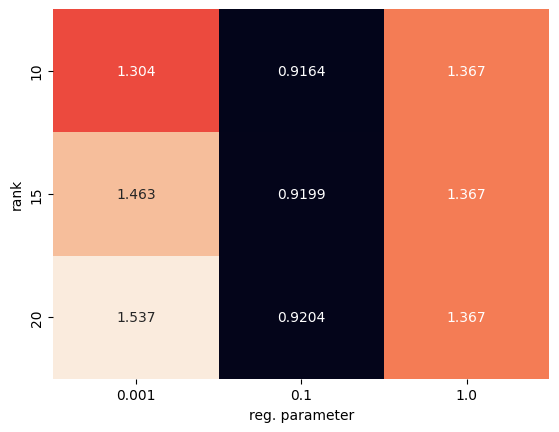

In [18]:
fig, ax = plt.subplots()
sns.heatmap(rmse_df, cbar=False, annot=True, fmt=".4g")

In [19]:
# Above we see that RMSE gets its highest value with rank=20 and regParam=0.001

In [20]:
# Top K recommendation

dfs_rec = model.recommendForAllUsers(10)
dfs_rec.show(10)

+------+--------------------+
|UserId|     recommendations|
+------+--------------------+
|     1|[{1536, 3.8742254...|
|     3|[{1536, 3.0857236...|
|     5|[{1536, 3.1859274...|
|     6|[{1536, 3.709467}...|
|     9|[{1536, 4.24253},...|
|    12|[{1536, 4.4972663...|
|    13|[{1536, 3.4071124...|
|    15|[{1536, 3.1946416...|
|    16|[{1536, 4.5356526...|
|    17|[{1536, 3.13858},...|
+------+--------------------+
only showing top 10 rows



In [21]:
# top K for a selected set of users

users = dfs_train.select(als.getUserCol()).distinct().limit(3)
dfs_rec_subset = model.recommendForUserSubset(users, 10)
dfs_rec_subset.show(10)


+------+--------------------+
|UserId|     recommendations|
+------+--------------------+
|   471|[{1536, 3.263929}...|
|   463|[{1536, 3.1270885...|
|   148|[{1536, 3.8723612...|
+------+--------------------+



In [ ]:
# Note: computing top-k recommendations for all users is the final step on a pipeline
# that includes training and scoring the model. Why?

# 1. Getting the top k from all user-item pairs requires a cross join which is usually very computationally expensive.
# 2. Inner products of user-item pairs are calculated individually instead of leveraging matrix block multiplication features which are available in certain contemporary computing acceleration libraries (e.g., BLAS).
# Find ways to optimize top k recommendations in Spark here: https://engineeringblog.yelp.com/2018/05/scaling-collaborative-filtering-with-pyspark.html


In [22]:
# clean spark instance
spark.stop()